In [1]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print(
    "GPU Name:",
    torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU",
)

PyTorch Version: 2.5.1+cu121
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import os
import re
from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoTokenizer

e:\Research\cuda_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define your label mapping
label2id = {
    "O": 0,
    "B-org": 1,
    "I-org": 2,
    "B-per": 3,
    "I-per": 4,
    "B-geo": 5,
    "I-geo": 6,
    # Add more if needed
}

# === Step 1: Load raw dataset ===
dataset = load_dataset(
    "text",
    data_files={
        "train": r"E:\Research\Datasets\Adapter_NER_data\Source_language( Task adapter)\marathi\naamapadam-train_mapped.txt",
        "test": r"E:\Research\Datasets\Adapter_NER_data\Source_language( Task adapter)\marathi\naamapadam-test_mapped.txt",
        "validation": r"E:\Research\Datasets\Adapter_NER_data\Source_language( Task adapter)\marathi\naamapadam-validation_mapped.txt",
    },
)


# === Step 2: Parse text lines ===
def parse_token_tag_pairs(split):
    lines = [line["text"].strip() for line in dataset[split] if line["text"].strip()]
    samples = []

    for i in range(0, len(lines), 2):
        if not lines[i].startswith("TOKENS:") or not lines[i + 1].startswith("TAGS:"):
            continue  # Skip invalid

        tokens = lines[i].replace("TOKENS:", "").strip().split()
        tags = lines[i + 1].replace("TAGS:", "").strip().split()

        if len(tokens) != len(tags):
            continue

        samples.append(
            {"tokens": tokens, "ner_tags": [label2id.get(tag, 0) for tag in tags]}
        )

    return samples


# === Step 3: Create DatasetDict ===
hf_dataset = DatasetDict(
    {
        "train": Dataset.from_list(parse_token_tag_pairs("train")),
        "validation": Dataset.from_list(parse_token_tag_pairs("validation")),
        "test": Dataset.from_list(parse_token_tag_pairs("test")),
    }
)

# === Step 4: Inspect ===
print("Example sample:\n", hf_dataset["train"][0])
print("Train size:", len(hf_dataset["train"]))

Example sample:
 {'tokens': ['विद्यापीठ', '/', 'राज्य', 'सरकार', '/', 'केंद्र', 'सरकार', '/', 'संबंधित', 'संस्थांचे', 'नियम'], 'ner_tags': [0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0]}
Train size: 455248


In [4]:
print(hf_dataset)
first_50 = hf_dataset["train"].select(range(50))
print(first_50)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 455248
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 2300
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1080
    })
})
Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 50
})


In [4]:
# === Step 4: Tokenization function ===
model_checkpoint = "ai4bharat/indic-bert"  # 🔁 Change if needed
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)  # 🔁 Change if needed


def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=128,
    )

    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)  # Special tokens
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])  # Use label of first subword
        else:
            labels.append(-100)  # Ignore subword tokens
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


# Apply the function to all splits
tokenized_dataset = hf_dataset.map(tokenize_and_align_labels, batched=False)

# Optional check
print(tokenized_dataset["train"][0])

Map: 100%|██████████| 1080/1080 [00:00<00:00, 3217.03 examples/s]

{'tokens': ['विद्यापीठ', '/', 'राज्य', 'सरकार', '/', 'केंद्र', 'सरकार', '/', 'संबंधित', 'संस्थांचे', 'नियम'], 'ner_tags': [0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0], 'input_ids': [2, 130, 2525, 1134, 1551, 6676, 166, 34886, 1134, 3841, 508, 166, 57597, 3841, 508, 166, 1539, 11339, 229, 152133, 4090, 232, 236, 44395, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

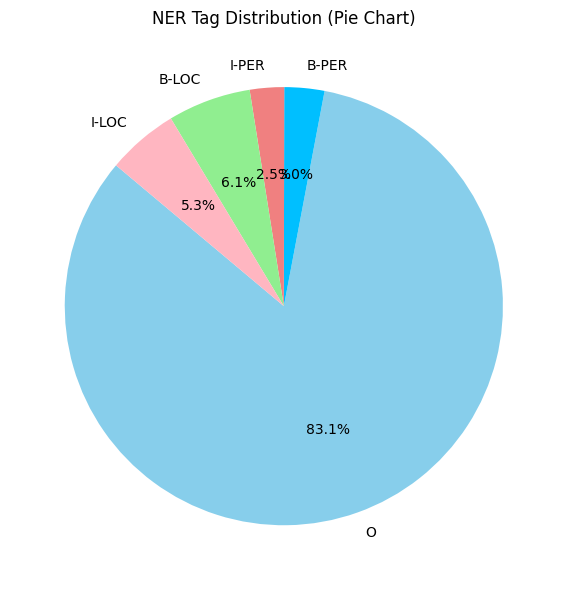

In [9]:
import matplotlib.pyplot as plt
from collections import Counter
from collections import Counter

tag_counter = Counter()

for split in ["train", "test", "validation"]:
    for sample in tokenized_dataset[split]:
        tag_counter.update(sample["ner_tags"])
# Example NER tag distribution (replace with your actual tag_counter)


# Mapping tag IDs to human-readable names
id2label = {
    0: "O",
    1: "B-PER",
    2: "I-PER",
    3: "B-LOC",
    4: "I-LOC",
    5: "B-ORG",
    6: "I-ORG",
}

# Prepare data for pie chart
labels = [id2label[i] for i in tag_counter.keys()]
sizes = list(tag_counter.values())
colors = [
    "skyblue",
    "deepskyblue",
    "lightcoral",
    "lightgreen",
    "lightpink",
    "lightyellow",
]

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)

# Chart styling
plt.title("NER Tag Distribution (Pie Chart)")
plt.tight_layout()
plt.show()

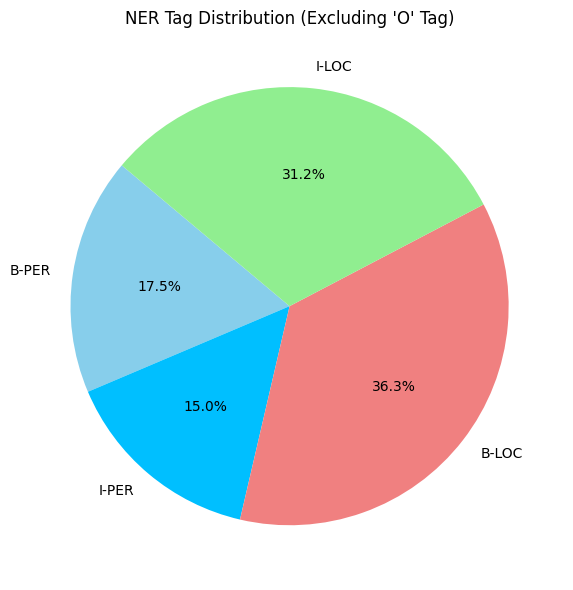

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

tag_counter = Counter()

for split in ["train", "test", "validation"]:
    for sample in tokenized_dataset[split]:
        tag_counter.update(sample["ner_tags"])
id2label = {
    0: "O",
    1: "B-PER",
    2: "I-PER",
    3: "B-LOC",
    4: "I-LOC",
    5: "B-ORG",
    6: "I-ORG",
}

# Filter out the 'O' tag (assuming its index is 0)
filtered_counter = {i: c for i, c in tag_counter.items() if id2label[i] != "O"}

# Prepare data
labels = [id2label[i] for i in filtered_counter]
sizes = list(filtered_counter.values())
colors = [
    "skyblue",
    "deepskyblue",
    "lightcoral",
    "lightgreen",
    "lightpink",
    "lightyellow",
]

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors)

# Chart styling
plt.title("NER Tag Distribution (Excluding 'O' Tag)")
plt.tight_layout()
plt.show()

In [6]:
train_dataset = tokenized_dataset["train"].select(range(50))
print(train_dataset.features)

{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [7]:
print("Training examples after filtering:", len(tokenized_dataset["train"]))
print("Validation examples:", len(tokenized_dataset["validation"]))

Training examples after filtering: 455248
Validation examples: 2300


In [8]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label2id),  # Ensure this matches your label count
    id2label={v: k for k, v in label2id.items()},
    label2id=label2id,
)

Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Remove non-numeric columns from tokenized_dataset
columns_to_remove = ["tokens", "ner_tags"]  # keep only model input columns
tokenized_dataset = tokenized_dataset.remove_columns(
    [col for col in columns_to_remove if col in tokenized_dataset["train"].column_names]
)

print(tokenized_dataset["train"])  # Should only show input_ids, attention_mask, labels

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 455248
})


In [10]:
from adapters import AutoAdapterModel
from transformers import AutoConfig

config = AutoConfig.from_pretrained(
    "ai4bharat/indic-bert",
)
model = AutoAdapterModel.from_pretrained(
    "ai4bharat/indic-bert",
    config=config,
)

In [11]:
from adapters import AdapterConfig

task_adapter_config = AdapterConfig.load("pfeiffer", reduction_factor=16)
config = AdapterConfig.load("pfeiffer", non_linearity="relu", reduction_factor=2)
#model.load_adapter("hi/wiki@ukp", config=config)
model.add_adapter("marathi_adapter", config=task_adapter_config)
model.add_tagging_head("marathi_adapter", num_labels=len(label2id))

In [12]:
model.train_adapter("marathi_adapter")

There are adapters available but none are activated for the forward pass.


In [13]:
model.set_active_adapters("marathi_adapter")

In [14]:
from adapters import AdapterTrainer
from transformers import TrainingArguments
from datasets import concatenate_datasets

training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=100,
    output_dir="./marathi_results",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

train_dataset = concatenate_datasets([dataset["train"], dataset["validation"]])

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"].select(range(1000)),
    eval_dataset=tokenized_dataset["validation"],
)

In [15]:
trainer.train()

Step,Training Loss
100,0.946800
200,0.597400
300,0.536100
400,0.498900
500,0.477000
600,0.471000


TrainOutput(global_step=640, training_loss=0.5800432056188584, metrics={'train_runtime': 374.9309, 'train_samples_per_second': 53.343, 'train_steps_per_second': 1.707, 'total_flos': 120694563840000.0, 'train_loss': 0.5800432056188584, 'epoch': 20.0})

In [17]:
model.save_adapter("./marathi_results", "marathi_adapter")